In [45]:
import networkx as nx
import pandas as pd
import ast
import matplotlib.pyplot as plt

## Recipe Graph

In [46]:
def create_recipe_ingredient_graph(recipes_df, min_common_ingredients=2):
    if isinstance(recipes_df['ingredients'].iloc[0], str):
        recipes_df['ingredients'] = recipes_df['ingredients'].apply(ast.literal_eval)
    G = nx.Graph()

    for _, row in recipes_df.iterrows():
        G.add_node(
            row['id'], 
            name=row['name'], 
            num_ingredients=len(row['ingredients']),
            ingredients=row['ingredients']
        )
    
    for i in range(len(recipes_df)):
        for j in range(i+1, len(recipes_df)):
            ingredients1 = set(recipes_df['ingredients'].iloc[i])
            ingredients2 = set(recipes_df['ingredients'].iloc[j])
          
            common_ingredients = ingredients1.intersection(ingredients2)
    
            if len(common_ingredients) >= min_common_ingredients:
                G.add_edge(
                    recipes_df['id'].iloc[i], 
                    recipes_df['id'].iloc[j], 
                    weight=len(common_ingredients),
                    common_ingredients=list(common_ingredients)
                )
    
    return G

In [47]:
def get_recipe_by_id(G, recipe_id):
    if recipe_id not in G.nodes():
        raise ValueError(f"Recipe ID {recipe_id} not found in the graph")
    
    node_data = G.nodes[recipe_id]
    return {
        'id': recipe_id,
        'name': node_data.get('name', 'Unknown'),
        'num_ingredients': node_data.get('num_ingredients', 0),
        'ingredients': node_data.get('ingredients', [])
    }


In [48]:
def find_most_connected_recipes(G, top_n=10):

    degrees = dict(G.degree())
    
    top_recipes = sorted(
        [(node, degree, G.nodes[node]['name']) for node, degree in degrees.items()], 
        key=lambda x: x[1], 
        reverse=True
    )[:top_n]
    
    return [
        {
            'id': recipe[0], 
            'connections': recipe[1], 
            'name': recipe[2]
        } 
        for recipe in top_recipes
    ]


In [49]:
def analyze_recipe_ingredient_graph(G):
    return {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'density': nx.density(G),
        'connected_components': nx.number_connected_components(G)
    }

In [50]:
recipes_df = pd.read_csv(r'recipes/RAW_recipes.csv')

In [51]:
recipes_df_small = recipes_df.head(500)

In [52]:
G_default = create_recipe_ingredient_graph(recipes_df_small, min_common_ingredients=2)
    
G_stricter = create_recipe_ingredient_graph(recipes_df_small, min_common_ingredients=5)
   
print("Default Graph Analysis (2 common ingredients):")
print(analyze_recipe_ingredient_graph(G_default))
    
print("\nStricter Graph Analysis (3 common ingredients):")
print(analyze_recipe_ingredient_graph(G_stricter))


C:\Users\vassa\AppData\Local\Temp\ipykernel_19924\1874502687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipes_df['ingredients'] = recipes_df['ingredients'].apply(ast.literal_eval)


Default Graph Analysis (2 common ingredients):
{'num_nodes': 500, 'num_edges': 13253, 'avg_degree': 53.012, 'density': 0.10623647294589178, 'connected_components': 47}

Stricter Graph Analysis (3 common ingredients):
{'num_nodes': 500, 'num_edges': 619, 'avg_degree': 2.476, 'density': 0.0049619238476953905, 'connected_components': 377}


In [54]:
nx.write_gml(G_default, 'recipe_graph_2_common_ingredients.gml')
nx.write_gml(G_stricter, 'recipe_graph_5_common_ingredients.gml')

In [ ]:
def visualize_graph(G, top_n=100, label_threshold=None):

    degrees = dict(G.degree())
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:top_n]
    
    H = G.subgraph(top_nodes)
    
    if label_threshold is None:
        sorted_degrees = sorted(degrees.values(), reverse=True)
        label_threshold = sorted_degrees[min(int(top_n * 0.2), len(sorted_degrees)-1)]
    
    plt.figure(figsize=(24,24))
    
    pos = nx.spring_layout(H, k=0.5, iterations=50, seed=42)
    
    node_sizes = [degrees[node]*20 for node in H.nodes()]
    node_colors = ['lightblue' if degrees[node] < label_threshold else 'salmon' for node in H.nodes()]
    
    nx.draw_networkx_nodes(H, pos, 
                            node_color=node_colors, 
                            node_size=node_sizes)
    
    nx.draw_networkx_edges(H, pos, 
                            width=0.3, 
                            alpha=0.5)
    
    labels = {
        node: G.nodes[node]['name'] 
        for node in H.nodes() 
        if degrees[node] >= label_threshold
    }
    nx.draw_networkx_labels(H, pos, 
                             labels, 
                             font_size=8, 
                             font_weight="bold")
    
    plt.title(f"Recipe Ingredient Graph - Top {top_n} Nodes (Labeled Nodes with Degree ≥ {label_threshold})")
    plt.axis('off')
    
    return plt.gcf()

C:\Users\vassa\AppData\Local\Temp\ipykernel_19924\3708480323.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  visualize_graph(G_default).show()


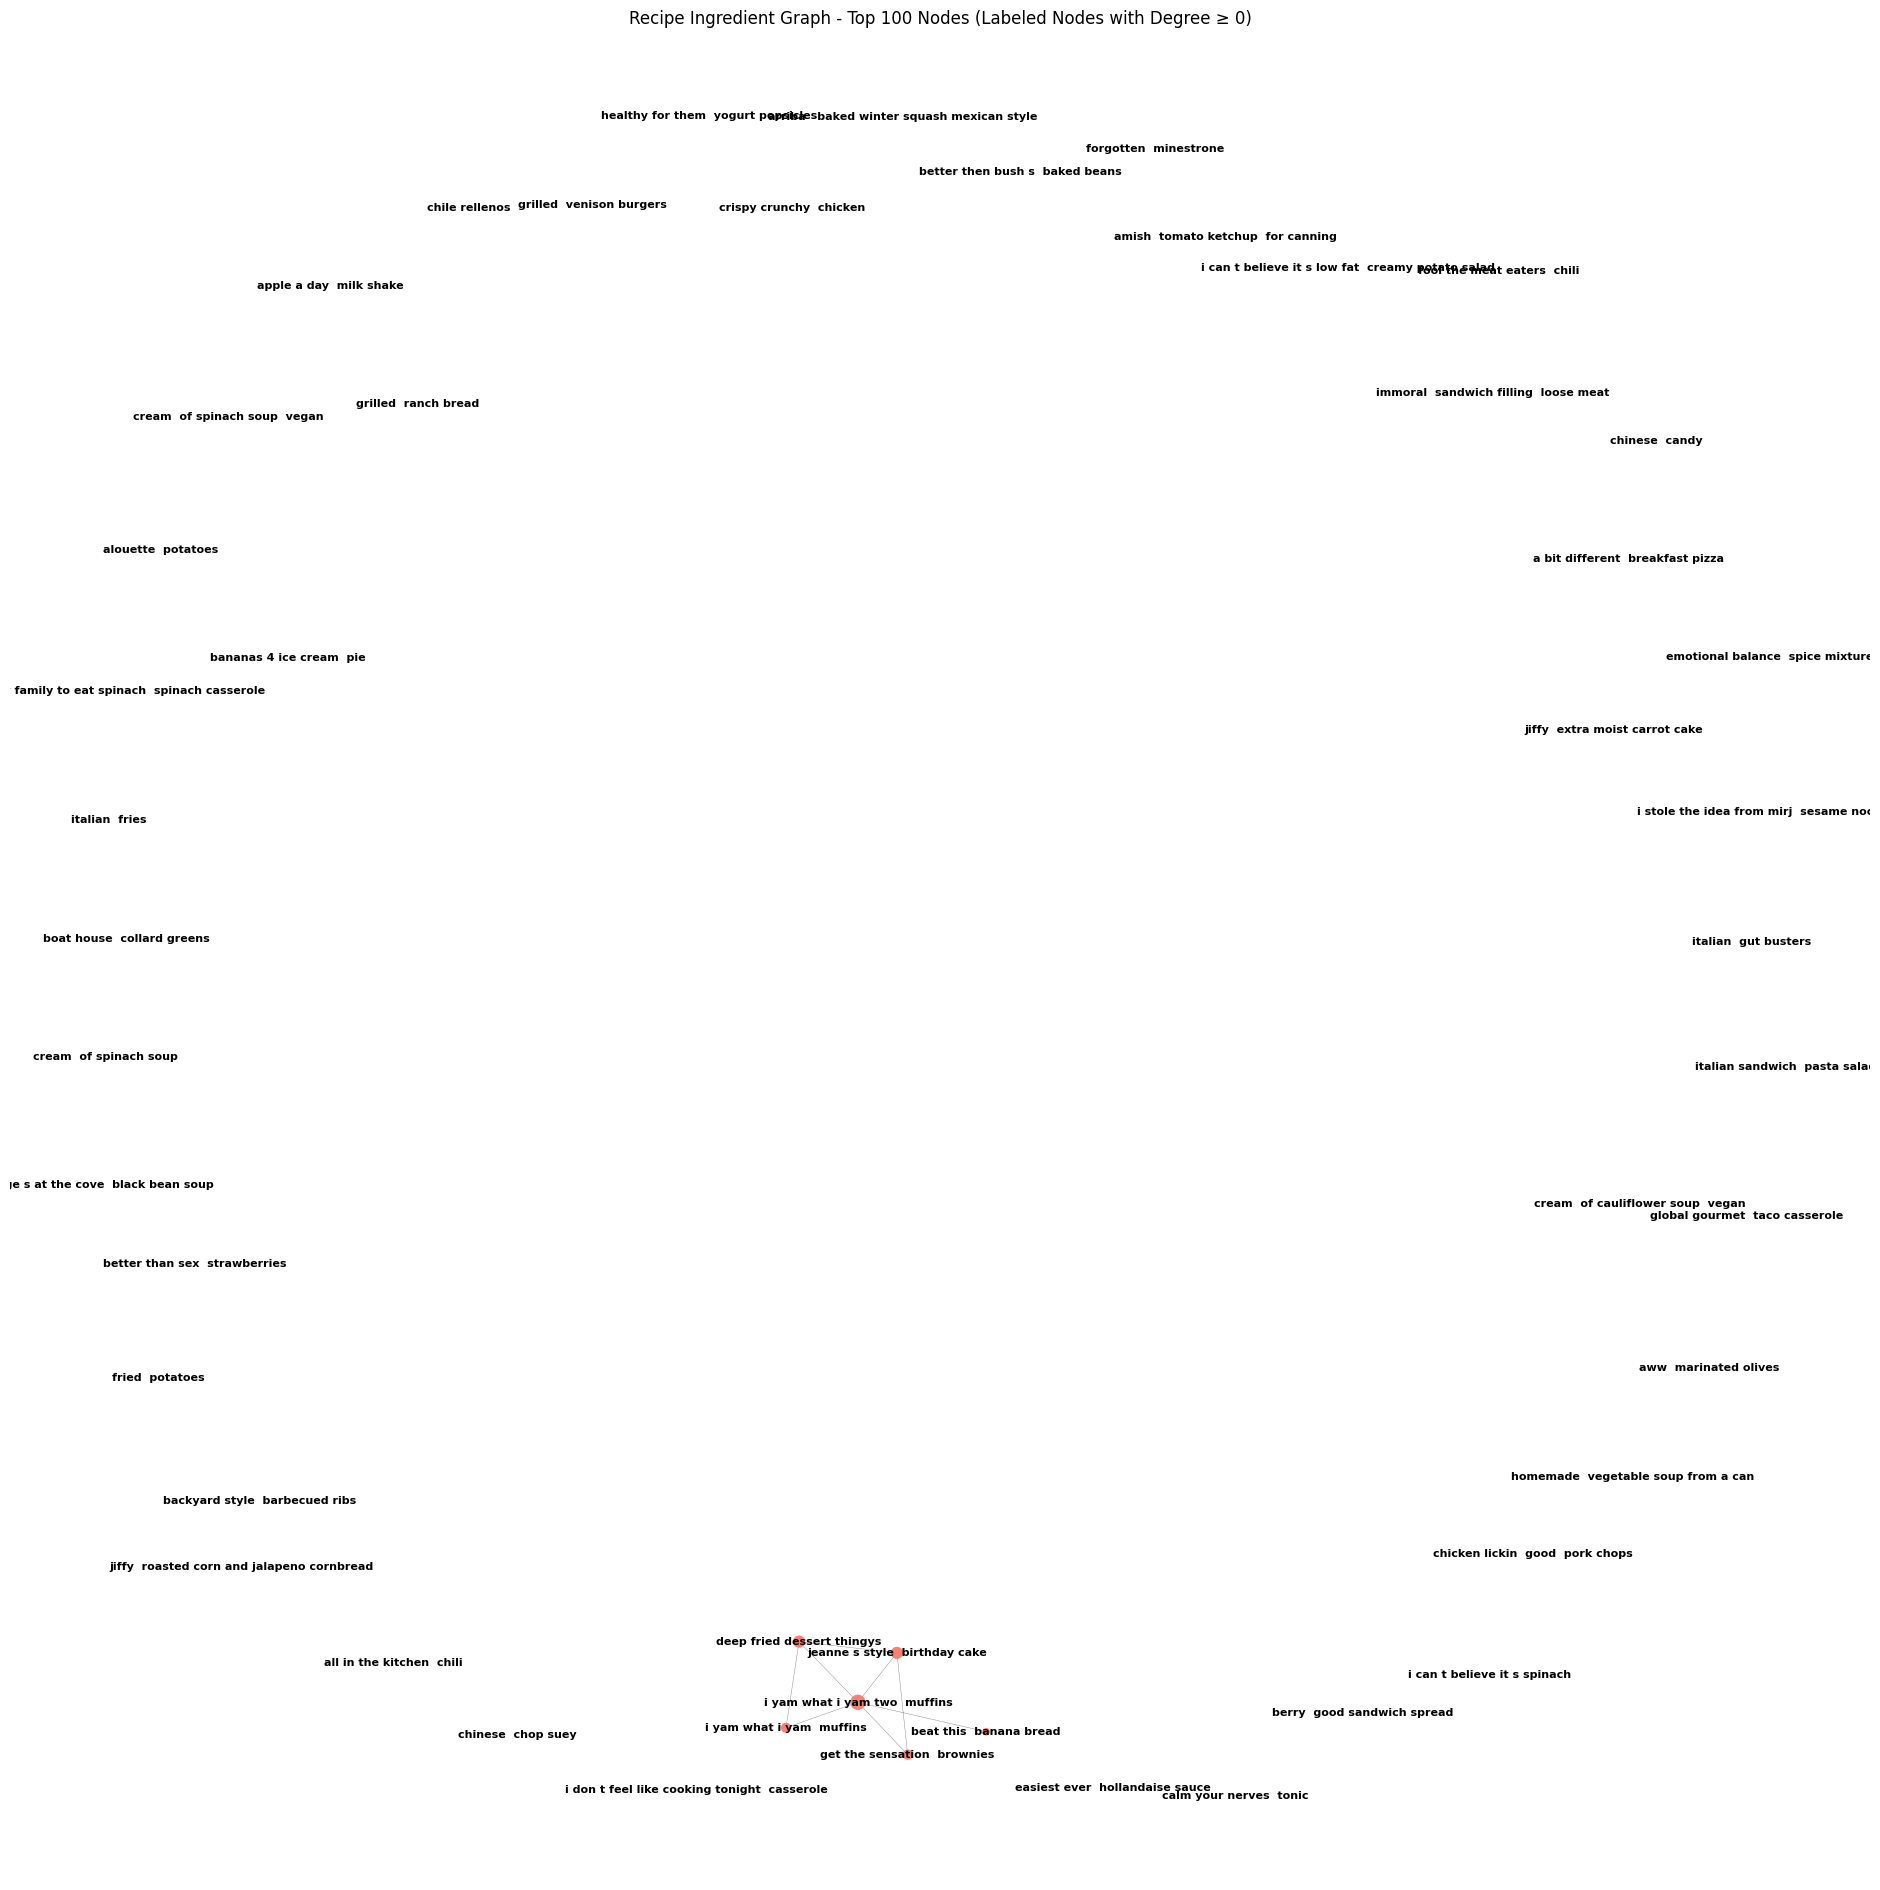

In [ ]:
visualize_graph(G_default).show()